<a href="https://colab.research.google.com/github/ulissigroup/amptorch/blob/active_learning/amptorch/active_learning/examples/neb_al_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Installation of packages

In [1]:
!pip install -q git+https://github.com/ulissigroup/amptorch.git@active_learning
!pip install -q git+https://github.com/mshuaibii/SIMPLE-NN.git
!pip install -q amp-atomistics
!pip install -q --upgrade dftbook

     |████████████████████████████████| 296kB 4.9MB/s 
     |████████████████████████████████| 6.7MB 21.0MB/s 
     |████████████████████████████████| 102kB 13.9MB/s 
     |████████████████████████████████| 2.1MB 55.1MB/s 
     |████████████████████████████████| 12.8MB 248kB/s 
     |████████████████████████████████| 110.5MB 36kB/s 
     |████████████████████████████████| 512kB 59.3MB/s 
     |████████████████████████████████| 3.8MB 54.5MB/s 
  ERROR: Failed building wheel for simple-nn
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
    Running setup.py install for simple-nn ... do

#### Build the NEBcalculator class, construct geometry and train with the active learner

In [2]:
! nvidia-smi

Thu May 28 00:09:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import copy
import os
import numpy as np
import random

import torch

from amptorch.active_learning.learner import AtomisticActiveLearner
from amptorch.active_learning.query_methods import random_query, max_uncertainty
from amptorch.active_learning.al_utils import CounterCalc, attach_sp_calc
from amptorch.model import CustomMSELoss

import ase
from ase.calculators.calculator import Calculator
from ase.calculators.emt import EMT
from ase.calculators.singlepoint import SinglePointCalculator as sp
from ase.optimize import QuasiNewton
from ase.neb import NEB, SingleCalculatorNEB
from ase.optimize import BFGS, FIRE, BFGSLineSearch
from ase import Atoms, Atom, units
from ase.build import molecule
from ase.visualize import view
from ase.io import read, write
from ase.build import fcc100, add_adsorbate,bcc100,fcc111
from ase.constraints import FixAtoms
from ase.neb import NEBTools

import dftbook
dftbook.setup_colab()
from espresso import Espresso

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 


Please be patient. This takes about 30 seconds.
Installing ASE
Installing ase-espresso
Installing pseudopotentials
Renaming pseudopotentials
Almost there, setting environment pseudopotential path
Installing MKL
Getting the GPU pw.x executable
Done installing GPU version of Quantum Espresso
Setup is complete. Please visit https://github.com/jkitchin/dft-book-espresso to find the tutorials.
Installation took 22.1 seconds


In [0]:
class NEBcalc:
    def __init__(self, starting_images, ml2relax=True, intermediate_samples=3):
      """
      Computes a NEB given an initial and final image.

      Parameters
      ----------
      starting_images: list. Initial and final images to be used for the NEB.

      ml2relax: boolean. True to use ML to relax the initial and final structure guesses. 
      False if initial and final structures were relaxed beforehand.
      
      intermediate_samples: int. Number of intermediate samples to be used in constructing the NEB"""
      
      self.starting_images = copy.deepcopy(starting_images)
      self.ml2relax = ml2relax
      self.intermediate_samples = intermediate_samples
      
    def run(self, calc, filename):
      """
      Runs NEB calculations.
      Parameters
      ----------
      calc: object. Calculator to be used to run method.
      filename: str. Label to save generated trajectory files."""
      
      initial = self.starting_images[0].copy()
      final = self.starting_images[-1].copy()
      if self.ml2relax:
        # Relax initial and final images
        ml_initial = initial
        ml_initial.set_calculator(calc)
        ml_final = final
        ml_final.set_calculator(calc)
        print('BUILDING INITIAL')
        qn = BFGS(ml_initial, trajectory='initial.traj', logfile='initial_relax_log.txt')
        qn.run(fmax=0.01, steps=100)
        print('BUILDING FINAL')
        qn = BFGS(ml_final, trajectory='final.traj', logfile='final_relax_log.txt')
        qn.run(fmax=0.01, steps=100)
        initial = ml_initial.copy()
        final = ml_final.copy()

      initial.set_calculator(calc)
      final.set_calculator(calc)

      images = [initial]
      for i in range(self.intermediate_samples):
        image = initial.copy()
        image.set_calculator(calc) 
        images.append(image)
      images.append(final)

      print('NEB BEING BUILT')
      neb = SingleCalculatorNEB(images)
      neb.interpolate()
      print('NEB BEING OPTIMISED')
      opti = BFGS(neb, trajectory=filename+".traj", logfile='al_neb_log.txt')
      opti.run(fmax=0.01, steps=100)
      print('NEB DONE')

      """ 
      The following code is used to visualise the NEB at every iteration 

      built_neb = NEBTools(images)
      barrier, dE = built_neb.get_barrier()
      max_force = built_neb.get_fmax()
      fig = built_neb.plot_band()
      plt.show()
      """
    def get_trajectory(self, filename):
      trajectory = ase.io.read(filename + ".traj", ":")
      return trajectory

In [0]:
#https://wiki.fysik.dtu.dk/ase/tutorials/neb/diffusion.html#diffusion-tutorial
#Surface Diffusion Energy Barriers
#Building your structure

def construct_geometries(parent_calc, ml2relax):
  counter_calc = CounterCalc(parent_calc)
  # Initial structure guess
  initial_slab = fcc100('Cu', size=(2, 2, 3))
  add_adsorbate(initial_slab, 'O', 1.7, 'hollow')
  initial_slab.center(axis=2, vacuum=4.0)
  mask = [atom.tag > 1 for atom in initial_slab]
  initial_slab.set_constraint(FixAtoms(mask=mask))

  initial_slab.set_calculator(counter_calc)

  # Final structure guess
  final_slab = initial_slab.copy()
  final_slab[-1].x += final_slab.get_cell()[0, 0] / 3
  final_slab.set_calculator(counter_calc)

  if not ml2relax:
    print('BUILDING INITIAL')
    qn = BFGS(initial_slab, trajectory='initial.traj', logfile='initial_relax_log.txt')
    qn.run(fmax=0.05, steps=100)
    print('BUILDING FINAL')
    qn = BFGS(final_slab, trajectory='final.traj', logfile='final_relax_log.txt')
    qn.run(fmax=0.05, steps=100)
    initial_slab = read("initial.traj", "-1")
    final_slab = read("final.traj", "-1")
  else:
    initial_slab = attach_sp_calc(initial_slab)
    final_slab = attach_sp_calc(final_slab)

  initial_force_calls = counter_calc.force_calls
  return initial_slab, final_slab, initial_force_calls

In [6]:
# Define symmetry functions
Gs = {}
Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
Gs["G2_rs_s"] = [0] * 4
Gs["G4_etas"] = [0.005]
Gs["G4_zetas"] = [1.0, 4.0]
Gs["G4_gammas"] = [+1.0, -1]
Gs["cutoff"] = 5.876798323827276  # EMT asap_cutoff: False

# Define morse parameters if Delta-ML model, o/w morse = False
morse_params = {
    "C": {"re": 0.972, "D": 6.379, "sig": 0.477},
    "O": {"re": 1.09, "D": 8.575, "sig": 0.603},
    "Cu": {"re": 2.168, "D": 3.8386, "sig": 1.696},
}

# Training parameters for the active learning framework
training_params = {
      "al_convergence": {"method": "iter", "num_iterations": 5},
      "samples_to_retrain": 5,
      "Gs": Gs,
      "morse": True,
      "morse_params": morse_params,
      "forcetraining": True,
      "cores": 1,
      "optimizer": torch.optim.LBFGS,
      "batch_size": 1000,
      "criterion": CustomMSELoss,
      "num_layers": 3,
      "num_nodes": 20,
      "force_coefficient": 0.04,
      "learning_rate": 1e-1,
      "epochs": 200,
      "test_split": 0,
      "shuffle": False,
      "verbose": 1,
      "filename": "neb_example",
      "file_dir": "./"
}

ml2relax = True
parent_calc = Espresso(pw=500.0, 
                calculation='scf',
                kpts=(4,4,1),
                xc='PBE')
initial, final, initial_force_calls = construct_geometries(parent_calc=parent_calc, ml2relax=ml2relax)
images = [initial]
images.append(final)

# Define AL scheme

learner = AtomisticActiveLearner(
    training_data=images,
    training_params=training_params,
    parent_calc=parent_calc,
    ensemble=False
)

# Learn the corresponding atomistic method
total_neb_images = 5  # N + 2 where N is the number of intermediate images and 2 is for initial and final structures

learner.learn(
    atomistic_method=NEBcalc(
        starting_images=images, 
        ml2relax=ml2relax, 
        intermediate_samples=total_neb_images-2), 
		query_strategy=random_query
	)

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0009          3.9024   391834.2188     +  0.2769


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


      2          0.0015          3.4303   302767.0000     +  0.1127
      3          0.0017          3.2835   277416.9688     +  0.1061
      4          0.0020          3.2627   273903.1250     +  0.1181
      5          0.0027          3.2439   270760.0312     +  0.1411
      6          0.0016          3.2914   278750.3438        0.1288
      7          0.0029          3.1503   255356.7031     +  0.1417
      8          3.1068          3.8985  6599943.5000        0.1396
      9        101.8997          3.8985  6679673856.0000        0.1387
     10          5.4012          3.8985  19156806.0000        0.1329
     11          2.3325          9.3075  5728608.0000        0.1362
     12          1.6130          5.5485  2465729.5000        0.1309
     13         14.7981          3.8985  141253136.0000        0.1308
     14          9.1976          3.8985  54807488.0000        0.1340
     15         22.7785          3.8985  334149856.0000        0.1379
     16          1.6183          3.8985

Visualize AL Results

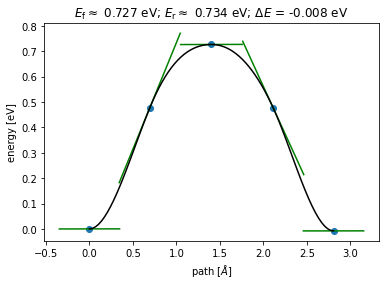

In [7]:
def neb_analysis(images, label, ax=None):
  nebtools = NEBTools(images)
  barrier, dE = nebtools.get_barrier()
  #max_force = nebtools.get_fmax()
  fig = nebtools.plot_band(ax=ax)
  fig.savefig(label+'.png', dpi=300)
  return barrier, dE

parent_calc = Espresso(pw=500.0, 
                calculation='scf',
                kpts=(4,4,1),
                xc='PBE')
images = read(f'neb_example_iter_5.traj@-5:')

# to verify ml_computed images...evaluate with parent calculator
'''emt_evaluated_images = []
for image in images:
  #image = image.copy()
  image.set_calculator(parent_calc)
  emt_evaluated_images.append(image)'''

barrier_ml, dE_ml = neb_analysis(images, label="ml_diffusion_neb")

In [8]:
'''barrier_emt_ml, dE_emt_ml, max_force_emt_ml = neb_analysis(emt_evaluated_images, label="emt@ml_diffusion_neb")
print(f"ML barrier pred = {barrier_ml}, ml dE pred = {dE_ml}, ml max force = {max_force_ml}")
print(f"emt@ml barrier = {barrier_emt_ml}, emt@ml dE = {dE_emt_ml}, emt@ml max force = {max_force_emt_ml}")'''
print(f"AL: Total number of force calls = {initial_force_calls} (initial data) + {learner.parent_calls} (AL-NEB) = {initial_force_calls+learner.parent_calls}")

AL: Total number of force calls = 2 (initial data) + 25 (AL-NEB) = 27


#### Code to generate true NEB

In [9]:
emt_counter = CounterCalc(Espresso(pw=500.0, 
                calculation='scf',
                kpts=(4,4,1),
                xc='PBE'))
if not ml2relax:
  # Load previously computed relaxed states
  initial_slab1 = read("initial.traj", "-1")
  final_slab1 = read("final.traj", "-1")
else:
  initial.set_calculator(emt_counter)
  final.set_calculator(emt_counter)
  qn = QuasiNewton(initial, trajectory='parent_initial.traj', logfile='initial_relax_log.txt')
  qn.run(fmax=0.05, steps=200)
  qn = QuasiNewton(final, trajectory='parent_final.traj', logfile='final_relax_log.txt')
  qn.run(fmax=0.05, steps=200)
  initial_slab1 = read("parent_initial.traj", "-1")
  final_slab1 = read("parent_final.traj", "-1")

images = [initial_slab1]
for i in range(3):
    image = final_slab1.copy()
    image.set_calculator(emt_counter)
    images.append(image)
images.append(final_slab1)

neb = SingleCalculatorNEB(images)
neb.interpolate()
qn = BFGS(neb, trajectory='actual_neb.traj')
qn.run(fmax=0.05)

      Step     Time          Energy         fmax
BFGS:    0 01:08:50   -66355.576542       11.9663
BFGS:    1 01:11:28   -66356.639946        8.4147
BFGS:    2 01:14:05   -66357.235387        6.0994
BFGS:    3 01:16:47   -66357.594111        4.4166
BFGS:    4 01:19:27   -66357.812533        3.1412
BFGS:    5 01:22:07   -66357.943976        2.1392
BFGS:    6 01:24:52   -66358.020565        1.3389
BFGS:    7 01:27:34   -66358.062305        0.6898
BFGS:    8 01:30:13   -66358.083550        0.6483
BFGS:    9 01:32:53   -66358.095467        0.8189
BFGS:   10 01:35:39   -66358.106851        0.8290
BFGS:   11 01:38:27   -66358.124399        0.6704
BFGS:   12 01:41:10   -66358.143488        0.3585
BFGS:   13 01:43:55   -66358.150924        0.1591
BFGS:   14 01:46:40   -66358.152269        0.1692
BFGS:   15 01:49:24   -66358.153175        0.2231
BFGS:   16 01:52:03   -66358.154685        0.2492
BFGS:   17 01:54:44   -66358.156307        0.1417
BFGS:   18 01:57:29   -66358.156774        0.0459


True

Ef = 0.7305919726350112, dE = 0.0005963375297142193
Total number of force calls = 86


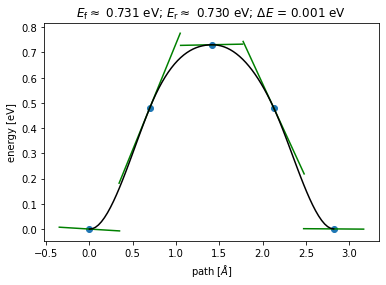

In [12]:
images = read(f'actual_neb.traj@-{total_neb_images}:')
nebtools = NEBTools(images)

Ef, dE = neb_analysis(images, label="actual_neb")

print(f"Ef = {Ef}, dE = {dE}")
print(f"Total number of force calls = {initial_force_calls+emt_counter.force_calls}")